# Error Analysis Step2
In this notebook, we are to investigate how VLM performs on comparision between a pair of similar images. This needs two steps: 1): recognize the reference object; 2) understand how the ref. object moves from source viewpoint to target viewpoint.

To be specific, we design two types of prompt. The first one is in zero-shot setup, which means model should select ref. object itself and state how the object moves. The second prompt is to use the given ref. object and state how the object moves.

Note that, image is in 2D-format, hence the object movement is from the following possible options:
1. up
2. down
3. left
4. right
5. forward
6. backward

In [5]:
from pathlib import Path

dataset_dir = Path("/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/demo")

c1_dir = dataset_dir / "single-dof-camera-motion-demo"
c2_dir = dataset_dir / "obj-centered-view-shift-demo"

import glob

def _read_c1_path_list(c1_dir: Path):
    c1_path_list = []
    for dof_dir in c1_dir.iterdir():
        if dof_dir.is_dir():
            for scene_dir in dof_dir.iterdir():
                if scene_dir.is_dir():
                    for seq_dir in scene_dir.iterdir():
                        if seq_dir.is_dir():
                            for pair_dir in seq_dir.iterdir():
                                if pair_dir.is_dir():
                                    src_dir = pair_dir / "source"
                                    tgt_dir = pair_dir / "target"

                                    src_img = glob.glob(str(src_dir / "*.color.png"))
                                    tgt_img = glob.glob(str(tgt_dir / "*.color.png"))

                                    c1_path_list.append((src_img[0], tgt_img[0]))
                            
    return c1_path_list


def _read_c2_path_list(c2_dir: Path):
    c2_path_list = []
    for tau_dir in c2_dir.iterdir():
        if tau_dir.is_dir():
            for scene_dir in tau_dir.iterdir():
                if scene_dir.is_dir():
                    for pair_dir in scene_dir.iterdir():
                        if pair_dir.is_dir():
                            src_dir = pair_dir / "source"
                            tgt_dir = pair_dir / "target"

                            src_img = glob.glob(str(src_dir / "*.jpg"))
                            tgt_img = glob.glob(str(tgt_dir / "*.jpg"))

                            c2_path_list.append((src_img[0], tgt_img[0]))
    
    return c2_path_list

c1_path_list = _read_c1_path_list(c1_dir)
c2_path_list = _read_c2_path_list(c2_dir)

c1_error_analysis_file = Path("/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/demo/error-analy-step2-c1.jsonl")
c2_error_analysis_file = Path("/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/demo/error-analy-step2-c2.jsonl")

## Pre-define

In [6]:
obj_move_options = ["left", "right", "up", "down", "closer", "farther"]

In [7]:
prompt_template = """<input>
You are given two images. The first image is the source viewpoint, and the second image is the target viewpoint.
</input>

<task>
Your task is to identify the reference object in the images. This should be an object that appears in both images and can be easily identified. If not provided, you need to choose an appropriate object that is visible and identifiable in both viewpoints. 

Once you have identified the reference object, you are given a set of answer candidates describing spatial relationships. Select the most accurate answer that describes how the reference object appears to have moved from the source viewpoint to the target viewpoint. Keep in mind that the apparent movement of the reference object may be due to the camera's movement, not the object itself.
</task>

{ref_obj}

<answer-candidates>
{answer_candidates}
</answer-candidates>

<output-format>
Please describe the reference object in <obj></obj> XML tags, and then output your answer in <ans></ans> XML tags. Do not output any other text.
</output-format>"""

## C1 Generation

In [8]:
from matplotlib import pyplot as plt
from PIL import Image
import json

def _show_images(image_paths: tuple):
    src_img, tgt_img = image_paths

    src_img = Image.open(src_img)
    tgt_img = Image.open(tgt_img)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(src_img)
    ax[0].set_title("Source Viewpoint")
    ax[0].axis("off")

    ax[1].imshow(tgt_img)
    ax[1].set_title("Target Viewpoint")
    ax[1].axis("off")

    plt.show()


i = 0
def _next(image_list: list):
    global i
    image_paths = next(image_list)
    i += 1
    _show_images(image_paths)
    print(f"Processing image pair {i}, remaining {len(c1_path_list) - i} pairs.")

    metadata_path = Path(image_paths[0]).parent.parent / "metadata.json"
    with open(metadata_path) as f:
        metadata = json.load(f)
    return image_paths, metadata


In [9]:
c1_iter = iter(c1_path_list)

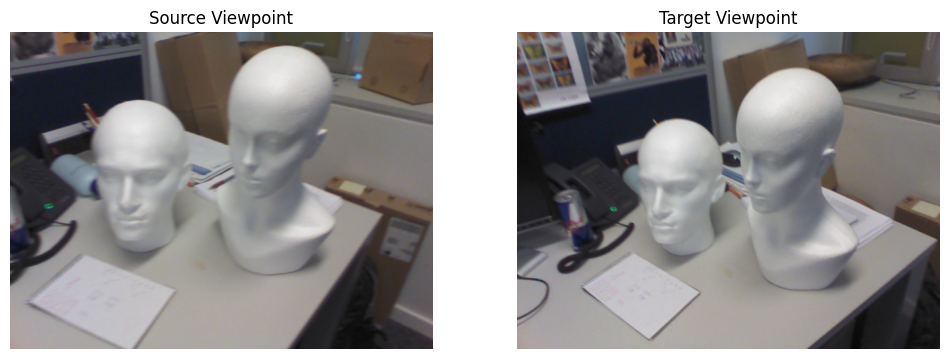

Processing image pair 1, remaining 28 pairs.
Degree of Freedom: phi
Sign: -


Collected ref. object: 
Written to /home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/demo/error-analy-step2-c1.jsonl successfully.


In [10]:
# Iterate images
image_paths, metadata = _next(c1_iter)
dof = metadata["significance"]
label = metadata["significance_text"]
sign = "+" if metadata[dof] > 0 else "-"
print(f"Degree of Freedom: {dof}\nSign: {sign}")

# 1. Collecting objects from user input
obj = input("Enter the reference object: ")
print(f"Collected ref. object: {obj}")

ref_obj_prompt = """<ref-obj>
{obj}
</ref-obj>"""
obj_prompt = ref_obj_prompt.format(obj=obj)

# 2. Generate answer candidates part
ans_cand_list = obj_move_options.copy()
import random
random.shuffle(ans_cand_list)
ans_cand_prompt = "\n".join(f"{ans}" for _, ans in enumerate(ans_cand_list))

# 3. Generate final prompt with 2 modes.
prompt_list = []
prompt = prompt_template.format(
    ref_obj="",
    answer_candidates=ans_cand_prompt,
)
prompt_list.append(prompt)
prompt = prompt_template.format(
    ref_obj=obj_prompt,
    answer_candidates=ans_cand_prompt,
)
prompt_list.append(prompt)

# 4. Label the object movement
label_list = []
while True:
    label = input("Enter the label for the object movement (left, right, up, down, closer, farther), enter 'done' to finish: ").strip().lower()
    if label == 'done':
        break
    elif label in obj_move_options:
        print(f"Selected label: {label}")
        label_list.append(label)
        continue
    else:
        print(f"Invalid label. Please choose from {obj_move_options}.")

# 5. Generate row
row = {
    "src_img_path": image_paths[0],
    "tgt_img_path": image_paths[1],
    "dof": dof,
    "sign": sign,

    "ref_obj": obj.lower(),
    "label": label_list,
    "prompt0": prompt_list[0],
    "prompt1": prompt_list[1],
}

# import jsonlines
# with jsonlines.open(c1_error_analysis_file, mode='a') as writer:
#     writer.write(row)
print(f"Written to {c1_error_analysis_file} successfully.")